# Import necessary modules

In [1]:
!pip install gensim

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Processing
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm
import random

# gensim
import gensim
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument

# Metrics
from sklearn import utils
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Prepare data

In [2]:
df = pd.read_csv("clean_compiled_transcripts.csv", index_col = "Participant_ID")
df.head()

,Transcript,PHQ_Score,PHQ_Binary
Participant_ID,,,
300,good atlanta georgia um my parents um i love i...,2,0
301,thank you mmm k i good thank you i los angeles...,3,0
302,i fine yourself i los angeles california part ...,4,0
303,okay bout yourself california yeah oh well it ...,0,0
304,i good um los angeles california um cool weath...,6,0


## Split the dataset (skip if you have the numpy data) 

In [3]:
X = df.Transcript
y = df.PHQ_Binary

In [4]:
def train_test(X, y, testfile='test_split_Depression_AVEC2017.csv'):
    test_participants = pd.read_csv(testfile)['participant_ID'].values
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for i in range(y.shape[0]):
        participant_no = y.index[i]
        
        if participant_no in test_participants:
            X_test.append(X[participant_no])
            y_test.append(y[participant_no])
        else:
            X_train.append(X[participant_no])
            y_train.append(y[participant_no])
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

X_train, X_test, y_train, y_test = train_test(X, y)

In [5]:
RANDOM_STATE = 42

# because the RandomUnderSampler does not work here
def undersampling(X_train, y_train):
    random.seed(RANDOM_STATE)
    
    neg_list = [i for i in range(len(y_train)) if y_train[i] == 0]
    pos_list = [i for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_list) < len(pos_list):
        minority_list = neg_list
        majority_list = pos_list
    else:
        minority_list = pos_list
        majority_list = neg_list
        
    sampled_list = random.sample(majority_list, len(minority_list))
    
    final_list = sampled_list + minority_list
    
    X_train_us = []
    y_train_us = []
    
    for i in final_list:
        X_train_us.append(X_train[i])
        y_train_us.append(y_train[i])
                                 
    return np.array(X_train_us), np.array(y_train_us)

X_train, y_train = undersampling(X_train, y_train)

In [6]:
# shuffle the train data in unison because data is in order
# reduces poor performance during k-cross validation when sampling data

X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82,), (45,), (82,), (45,))

## Label sentences (skip if you have the numpy data)

In [7]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [8]:
X_train = label_sentences(X_train, 'train')
X_test = label_sentences(X_test, 'test')
all_data = X_train + X_test

all_data[:10]

[TaggedDocument(words=['yes', 'i', 'fine', 'california', 'los', 'angeles', 'mhm', 'um', 'i', 'love', 'near', 'beach', 'um', 'i', 'love', 'beach', 'i', 'love', 'um', 'living', 'big', 'city', 'um', 'i', 'love', 'fact', 'i', 'lots', 'friends', 'family', 'mm', 'traffic', 'um', 'many', 'sometimes', 'many', 'people', 'apart', 'i', 'i', 'generally', 'happy', 'photography', 'language', 'studies', 'mhm', 'um', 'i', 'love', 'photography', 'i', 'always', 'interested', 'it', 'studied', 'it', 'high', 'school', 'well', 'i', 'wanted', 'continue', 'learn', 'it', 'languages', 'i', 'come', 'mixed', 'background', 'i', 'wanted', 'learn', 'languages', 'my', 'ethnic', 'background', 'it', 'um', 'it', 'hard', 'it', 'passion', 'i', 'enjoyed', 'it', 'i', 'um', 'photography', 'full', 'time', 'also', 'things', 'i', 'passionate', 'um', 'creatively', 'creative', 'things', 'i', 'idea', 'i', 'would', 'like', 'um', 'make', 'robe', 'ah', 'like', 'robe', 'line', 'um', 'womens', 'robes', 'things', 'like', 'mhm', 'i', 'i'

# Train doc2vec model (skip if you have the numpy data)
Parameters:
* dm=0: distributed bag of words (DBOW) is used
* vector_size=300: 300 vector dimensional feature vectors
* negative=5: specifies how many "noise words" should be drawn
* min_count=1: ignores all words with total frequency lower than this
* alpha=0.065: the initial learning rate

In [9]:
model_dbow = doc2vec.Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 127/127 [00:00<00:00, 332507.25it/s]


In [10]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), 
                     total_examples=len(all_data), 
                     epochs=1)  #shuffle the data and use all data exactly once
    model_dbow.alpha -= 0.002 #set the learning rate
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 127/127 [00:00<00:00, 562488.50it/s]


In [11]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

X_train = get_vectors(model_dbow, len(X_train), 300, 'train')
X_test = get_vectors(model_dbow, len(X_test), 300, 'test')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82, 300), (45, 300), (82,), (45,))

In [12]:
np.save("X_train_doc2vec.npy", X_train)
np.save("X_test_doc2vec.npy", X_test)
np.save("y_train_doc2vec.npy", y_train)
np.save("y_test_doc2vec.npy", y_test)

# Load dataset

In [13]:
X_train = np.load("X_train_doc2vec.npy")
X_test = np.load("X_test_doc2vec.npy")
y_train = np.load("y_train_doc2vec.npy")
y_test = np.load("y_test_doc2vec.npy")

# More preprocessing

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. Hence we will focus on `f1 score` and `recall` for the positive class.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [14]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## k cross 

In [15]:
def k_cross(input_model, X=X_train, y=y_train, k=4, n=3, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
        
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
                
        model = clone(input_model) # prevents incremental fitting
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

## Evaluate model

In [16]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Logistic Regression 

best scores: f1 = 0.5529993691225575, recall = 0.5769635457135457
[0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1
 1 1 0 1 1 1 0 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.618663594470046
              precision    recall  f1-score   support

           0       0.82      0.45      0.58        31
           1       0.39      0.79      0.52        14

    accuracy                           0.56        45
   macro avg       0.61      0.62      0.55        45
weighted avg       0.69      0.56      0.56        45

Confusion Matrix: 
 [[14 17]
 [ 3 11]]


LogisticRegression(C=10, n_jobs=3)

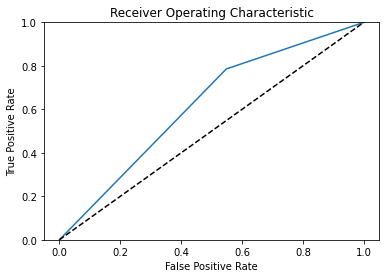

In [17]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_logreg_f1_model = find_best_logreg_model(6)
evaluate_model(best_logreg_f1_model)

## Decision Tree

best scores: f1 = 0.49709463877084015, recall = 0.4799177674177674
[0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 0 0 1 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.599078341013825
              precision    recall  f1-score   support

           0       0.79      0.48      0.60        31
           1       0.38      0.71      0.50        14

    accuracy                           0.56        45
   macro avg       0.59      0.60      0.55        45
weighted avg       0.66      0.56      0.57        45

Confusion Matrix: 
 [[15 16]
 [ 4 10]]


DecisionTreeClassifier(max_depth=2, min_samples_leaf=14, random_state=42)

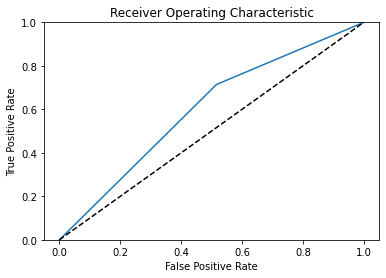

In [18]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                best_f1 = f1
                best_recall = recall
                best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_tree_f1_model = find_best_tree_model(20, 30)
evaluate_model(best_tree_f1_model)

## Random Forest

best scores: f1 = 0.5532454186630388, recall = 0.5691563066563067
[0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1
 1 1 1 0 1 0 1 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.49193548387096775
              precision    recall  f1-score   support

           0       0.68      0.48      0.57        31
           1       0.30      0.50      0.38        14

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.47        45
weighted avg       0.56      0.49      0.51        45

Confusion Matrix: 
 [[15 16]
 [ 7  7]]


RandomForestClassifier(n_estimators=5, random_state=42)

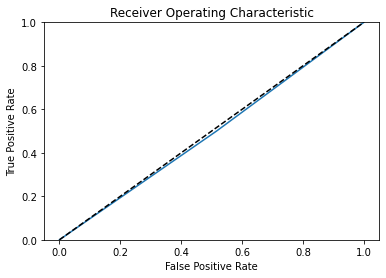

In [19]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_forest_f1_model = find_best_forest_model(30)
evaluate_model(best_forest_f1_model)

## SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 151 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


f1 mean score: 0.5950082667180268
recall mean score: 0.814050764050764
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.31      1.00      0.47        14

    accuracy                           0.31        45
   macro avg       0.16      0.50      0.24        45
weighted avg       0.10      0.31      0.15        45

Confusion Matrix: 
 [[ 0 31]
 [ 0 14]]
Best SVM parameters: {'C': 1, 'degree': 4, 'kernel': 'poly'}


[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.9s finished
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


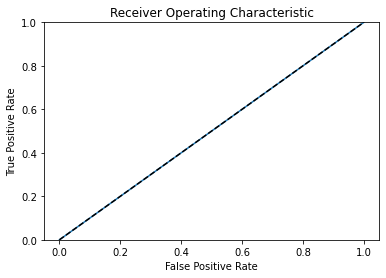

In [20]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

f1_scores, recall_scores = k_cross(svm_model_cv)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")